In [1]:
# Import library for exploring dataset
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

  <font size="+2">**Importing Data Set**</font>

The objective being the prediction of prices for different real estate values, we will be tailoring our data around that.

In [2]:
data = pd.read_excel('../input/AgencyDataset/AgencyDataset.xlsx')
data.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-02,313000.0,3,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,2014-05-02,2384000.0,5,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119,USA
2,2014-05-02,342000.0,3,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA
3,2014-05-02,420000.0,3,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,857 170th Pl NE,Bellevue,WA 98008,USA
4,2014-05-02,550000.0,4,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,9105 170th Ave NE,Redmond,WA 98052,USA


In [3]:
data.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated
count,4.600000e+03,4600.000000,4600.000000,4600.000000,4.600000e+03,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000
mean,5.519630e+05,3.400870,2.160815,2139.346957,1.485252e+04,1.512065,0.007174,0.240652,3.451739,1827.265435,312.081522,1970.786304,808.608261
std,5.638347e+05,0.908848,0.783781,963.206916,3.588444e+04,0.538288,0.084404,0.778405,0.677230,862.168977,464.137228,29.731848,979.414536
min,0.000000e+00,0.000000,0.000000,370.000000,6.380000e+02,1.000000,0.000000,0.000000,1.000000,370.000000,0.000000,1900.000000,0.000000
25%,3.228750e+05,3.000000,1.750000,1460.000000,5.000750e+03,1.000000,0.000000,0.000000,3.000000,1190.000000,0.000000,1951.000000,0.000000
50%,4.609435e+05,3.000000,2.250000,1980.000000,7.683000e+03,1.500000,0.000000,0.000000,3.000000,1590.000000,0.000000,1976.000000,0.000000
75%,6.549625e+05,4.000000,2.500000,2620.000000,1.100125e+04,2.000000,0.000000,0.000000,4.000000,2300.000000,610.000000,1997.000000,1999.000000
max,2.659000e+07,9.000000,8.000000,13540.000000,1.074218e+06,3.500000,1.000000,4.000000,5.000000,9410.000000,4820.000000,2014.000000,2014.000000


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4600 entries, 0 to 4599
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           4600 non-null   datetime64[ns]
 1   price          4600 non-null   float64       
 2   bedrooms       4600 non-null   int64         
 3   bathrooms      4600 non-null   float64       
 4   sqft_living    4600 non-null   int64         
 5   sqft_lot       4600 non-null   int64         
 6   floors         4600 non-null   float64       
 7   waterfront     4600 non-null   int64         
 8   view           4600 non-null   int64         
 9   condition      4600 non-null   int64         
 10  sqft_above     4600 non-null   int64         
 11  sqft_basement  4600 non-null   int64         
 12  yr_built       4600 non-null   int64         
 13  yr_renovated   4600 non-null   int64         
 14  street         4600 non-null   object        
 15  city           4600 n

In [5]:
# Check for duplicated rows
print("Number of duplicate rows: ", sum(data.duplicated()))

Number of duplicate rows:  0


  <font size="+2">**Data Cleaning**</font>

First & foremost, check for na data.

In [6]:
data.isna().sum()
#Value might change after encoding object types

date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
street           0
city             0
statezip         0
country          0
dtype: int64

We will be dropping the date collumn from the Data as it's irrelevent to the price prediction!

In [7]:
data = data.drop(['date'], axis = 1)
data.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,313000.0,3,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,2384000.0,5,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119,USA
2,342000.0,3,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA
3,420000.0,3,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,857 170th Pl NE,Bellevue,WA 98008,USA
4,550000.0,4,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,9105 170th Ave NE,Redmond,WA 98052,USA


In [8]:
data["country"].nunique()

1

In [9]:
data[['state','zip_code']] = data.statezip.str.split(" ",expand=True,)
data['state'].nunique()
data.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country,state,zip_code
0,313000.0,3,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA,WA,98133
1,2384000.0,5,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119,USA,WA,98119
2,342000.0,3,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA,WA,98042
3,420000.0,3,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,857 170th Pl NE,Bellevue,WA 98008,USA,WA,98008
4,550000.0,4,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,9105 170th Ave NE,Redmond,WA 98052,USA,WA,98052


As we checked, country only possessed 1 value so we're gonna drop it.
Seperating statezip into 2 features also shows that WA is the only state we're working with here so we're gonna keep just the numerical value to avoid having to encode it.
We're also dropping the street collumn as it seems irrelevent.

In [10]:
data=data.drop(['country','state','statezip'],axis=1)


In [11]:
data=data.drop(['street'],axis=1)


In [12]:
data.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,city,zip_code
0,313000.0,3,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,Shoreline,98133
1,2384000.0,5,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,Seattle,98119
2,342000.0,3,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,Kent,98042
3,420000.0,3,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,Bellevue,98008
4,550000.0,4,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,Redmond,98052


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4600 entries, 0 to 4599
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          4600 non-null   float64
 1   bedrooms       4600 non-null   int64  
 2   bathrooms      4600 non-null   float64
 3   sqft_living    4600 non-null   int64  
 4   sqft_lot       4600 non-null   int64  
 5   floors         4600 non-null   float64
 6   waterfront     4600 non-null   int64  
 7   view           4600 non-null   int64  
 8   condition      4600 non-null   int64  
 9   sqft_above     4600 non-null   int64  
 10  sqft_basement  4600 non-null   int64  
 11  yr_built       4600 non-null   int64  
 12  yr_renovated   4600 non-null   int64  
 13  city           4600 non-null   object 
 14  zip_code       4600 non-null   object 
dtypes: float64(3), int64(10), object(2)
memory usage: 539.2+ KB


As we can see, we need to encode the zip_code & city.
Note 1: We could convert zip_code to a 16bit integer value but that could lead to wrong assumptions by the model so adding a dict & encoding seems to be the best solution for now.

In [14]:
from sklearn.preprocessing import LabelEncoder
print('Categorical columns: ')
for col in data.columns:
    if data[col].dtype == 'object':
        values = data[col].value_counts()
        values = dict(values)
        
        print(str(col))
        label = LabelEncoder()
        label = label.fit(data[col])
        data[col] = label.transform(data[col].astype(str))
        
        new_values = data[col].value_counts()
        new_values = dict(new_values)
        
        value_dict = {}
        i=0
        for key in values:
            value_dict[key] = list(new_values)[i]
            i+= 1
        print(value_dict)

Categorical columns: 
city
{'Seattle': 35, 'Renton': 32, 'Bellevue': 3, 'Redmond': 31, 'Issaquah': 16, 'Kirkland': 19, 'Kent': 18, 'Auburn': 1, 'Sammamish': 33, 'Federal Way': 14, 'Shoreline': 36, 'Woodinville': 42, 'Maple Valley': 21, 'Mercer Island': 23, 'Burien': 6, 'Snoqualmie': 38, 'Kenmore': 17, 'Des Moines': 10, 'North Bend': 27, 'Covington': 9, 'Duvall': 11, 'Lake Forest Park': 20, 'Bothell': 5, 'Newcastle': 25, 'SeaTac': 34, 'Tukwila': 40, 'Vashon': 41, 'Enumclaw': 12, 'Carnation': 7, 'Normandy Park': 26, 'Clyde Hill': 8, 'Medina': 22, 'Fall City': 13, 'Black Diamond': 4, 'Ravensdale': 30, 'Pacific': 28, 'Algona': 0, 'Yarrow Point': 43, 'Skykomish': 37, 'Preston': 29, 'Milton': 24, 'Inglewood-Finn Hill': 15, 'Snoqualmie Pass': 39, 'Beaux Arts Village': 2}
zip_code
{'98103': 47, '98052': 31, '98117': 56, '98115': 54, '98006': 5, '98059': 37, '98042': 26, '98034': 22, '98053': 32, '98074': 42, '98038': 23, '98027': 15, '98023': 13, '98058': 36, '98133': 62, '98125': 60, '98033':

In [15]:
data.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,city,zip_code
0,313000.0,3,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,36,62
1,2384000.0,5,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,35,58
2,342000.0,3,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,18,26
3,420000.0,3,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,3,7
4,550000.0,4,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,31,31


In [16]:
data.isna().sum()

price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
city             0
zip_code         0
dtype: int64

Okay so even after encoding, no non available or duplicates seem to appear so mostly cleaned data.

In [17]:
#Rounding up values to get more accurate data later on
data = (data.loc[:, ~data.columns.isin(['lat', 'long'])]).round(0).astype(int)
data.head(5)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,city,zip_code
0,313000,3,2,1340,7912,2,0,0,3,1340,0,1955,2005,36,62
1,2384000,5,2,3650,9050,2,0,4,5,3370,280,1921,0,35,58
2,342000,3,2,1930,11947,1,0,0,4,1930,0,1966,0,18,26
3,420000,3,2,2000,8030,1,0,0,4,1000,1000,1963,0,3,7
4,550000,4,2,1940,10500,1,0,0,4,1140,800,1976,1992,31,31


  <font size="+2">**Data Analysis**</font>

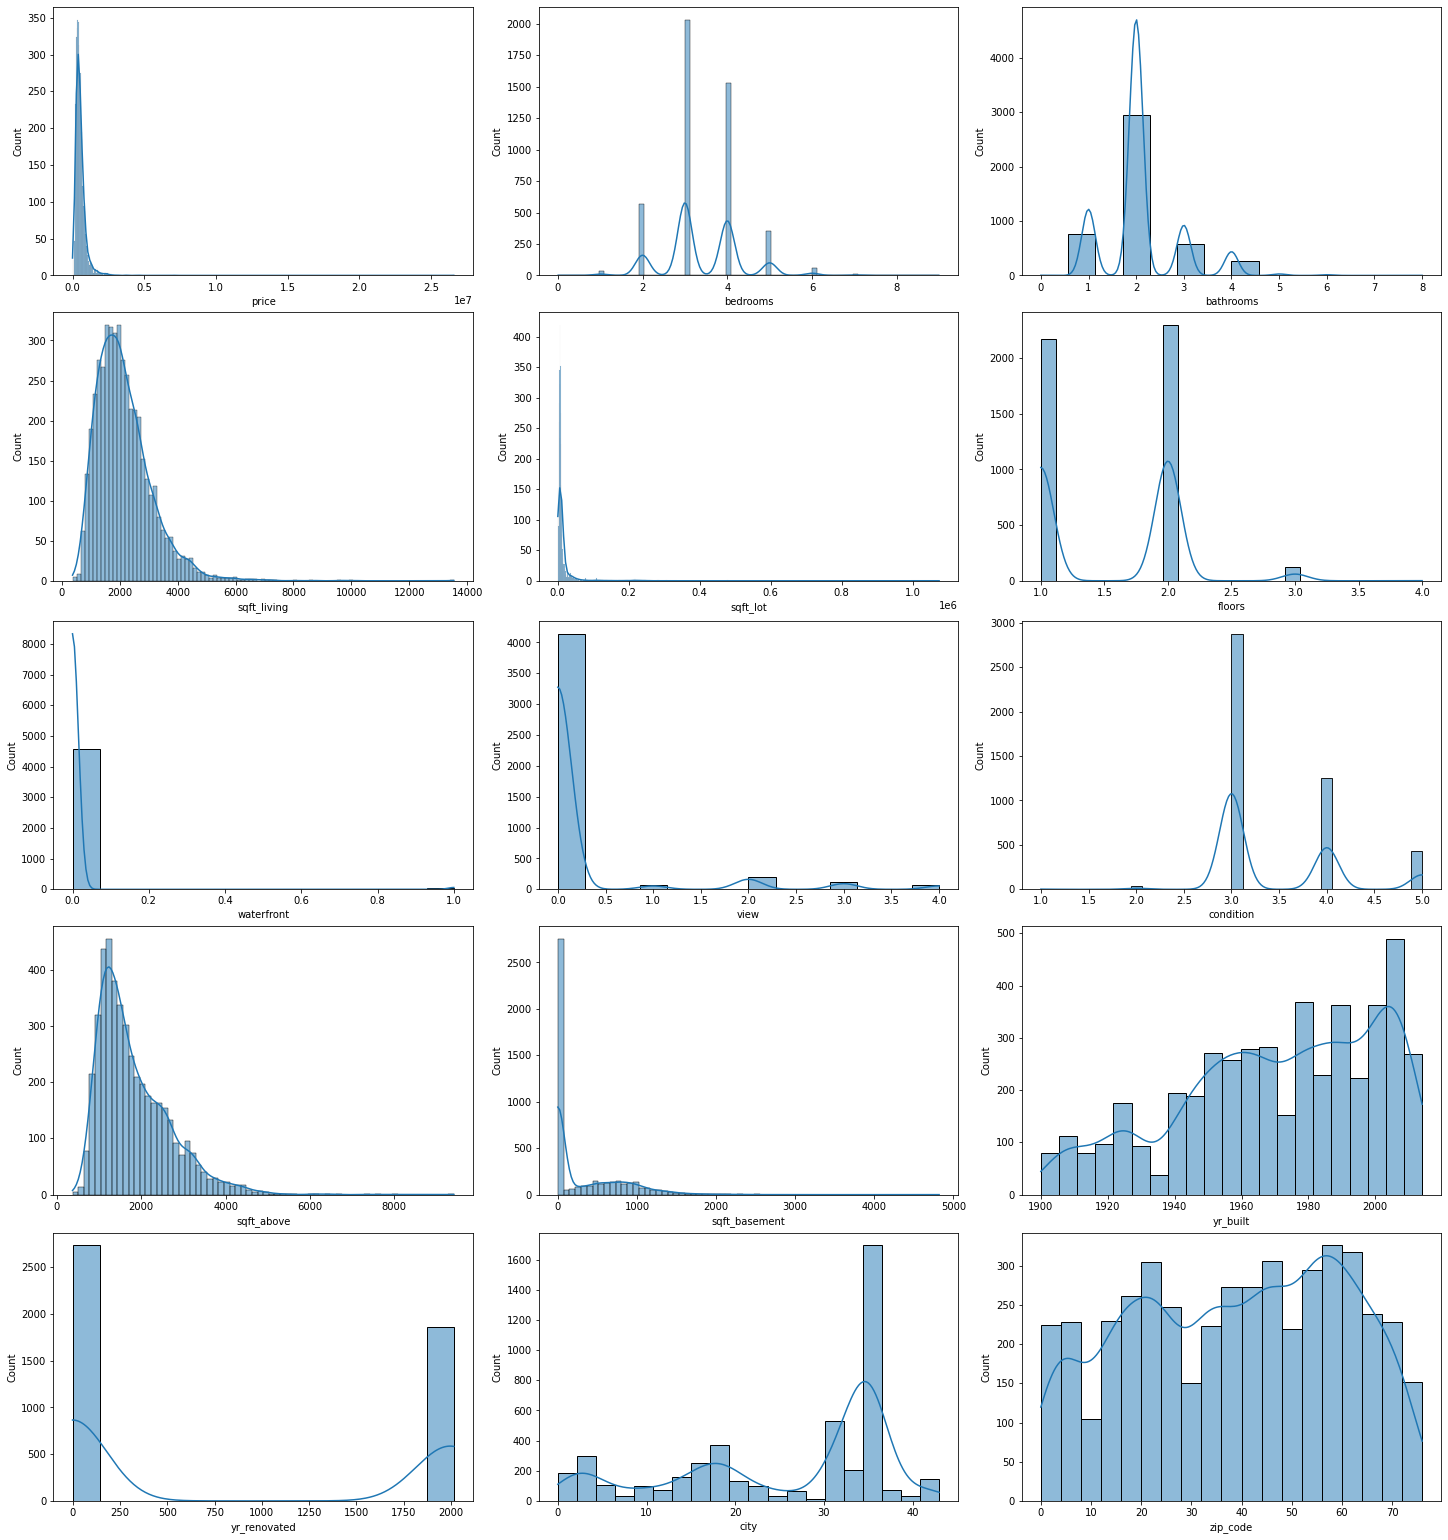

In [18]:
# Graph each variable's distribution
fig = plt.figure(figsize=(20, 25), constrained_layout=True)
for i in range(len(data.columns)):
    plt.subplot(6, 3, i+1)
    sns.histplot(data=data, x=data[data.columns[i]], kde=True)

With this figure, we can get an approximate estimation to the mean of each feature & therefore know which majority is in which interval.

But what we need to know is the correlation of each feature with the price.

Since the target feature is price, we will correlate all other features to it.

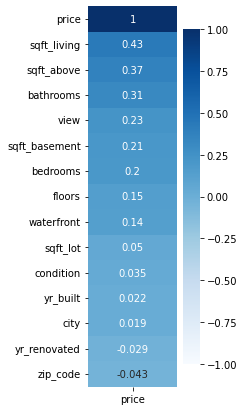

In [19]:
# Correlating features with target
plt.figure(figsize=(2, 7))
heatmap = sns.heatmap(data.corr()[['price']]
                      .sort_values(by='price', ascending=False),
                      vmin=-1, vmax=1, annot=True, cmap='Blues')

As we can see, price has its strongest correlations with sqft_living,sqft_above and bathrooms

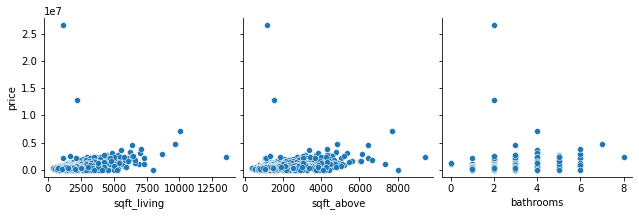

In [20]:
# Pairplot variable target with strong correlation variables target -with
sns.pairplot(data, x_vars=['sqft_living', 'sqft_above', 'bathrooms'],
             y_vars=['price'], height=3, aspect=1)


Based on the pairplot above, we can see that :

the higher each variable is, the higher the price is.
We can see 2 points that are too far away from the clusters, we can assume those are clusters or VERY particular data.

In [21]:
# Describe the small amount variable
sav = data[(['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition'])]

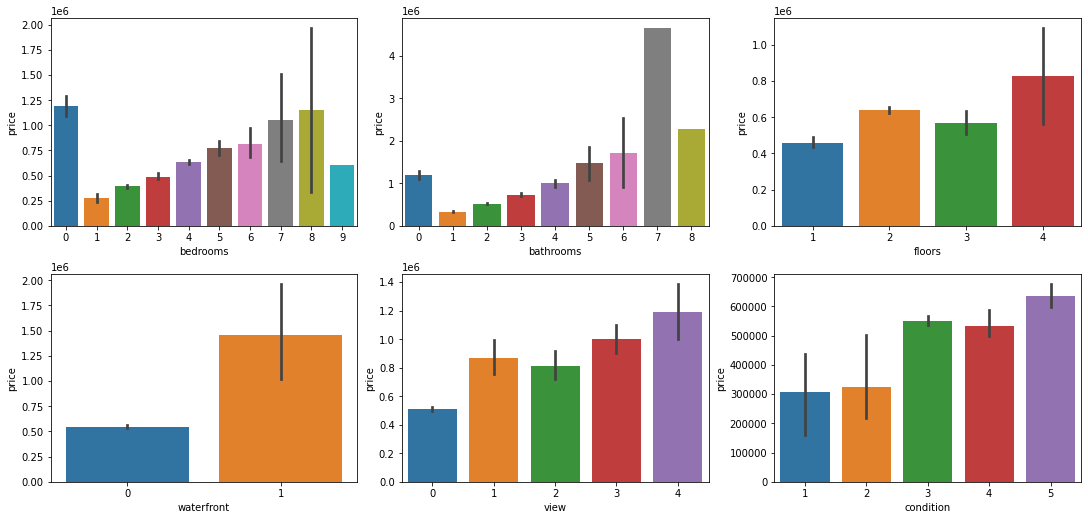

In [22]:

fig = plt.figure(figsize=(15,10), constrained_layout=True)
for i in range(len(sav.columns)):
    plt.subplot(3, 3, i+1)
    sns.barplot(data=sav, x=sav[sav.columns[i]], y=data['price'])

What we can take away from this are 2 things: 
The 0 bedroom places's value must be the occurance of a lot of outliers since no way a 0 bedroom home is higher praced than a 7-8 one.
Bathroom value seems accurate except for 2 things, the 0 bathroom value is too hight as well as the 7 one, we will be checking for outliers for that one too.
The rest seems fine.

**Outlier Detection**

In [23]:
df1=data.drop(["price"],axis=1)

<AxesSubplot:>

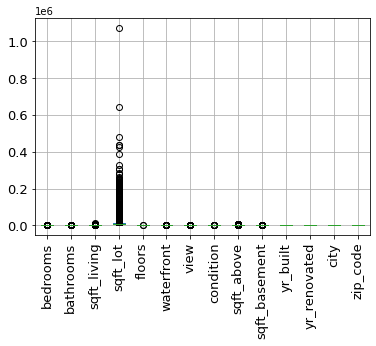

In [24]:
# Outlier detection
df1.boxplot(grid=True, rot=90, fontsize=13)